In [141]:
import pandas as pd
import datetime as dt
import numpy as np

import plotly.express as px

In [142]:
url = 'https://raw.githubusercontent.com/neylsoncrepalde/projeto_eda_covid/master/covid_19_data.csv'

In [143]:
#transform date comlumns to datetime format together with the dataframe creation...
df = pd.read_csv(url, parse_dates = ['ObservationDate', 'Last Update'])

In [144]:
df.dtypes

SNo                         int64
ObservationDate    datetime64[ns]
Province/State             object
Country/Region             object
Last Update        datetime64[ns]
Confirmed                 float64
Deaths                    float64
Recovered                 float64
dtype: object

In [145]:
df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


## Refining Columns

In [146]:
df.columns

Index(['SNo', 'ObservationDate', 'Province/State', 'Country/Region',
       'Last Update', 'Confirmed', 'Deaths', 'Recovered'],
      dtype='object')

In [147]:
import re

#re.sub(r'[/| ]', '') - will remove special characters(/ or empty spaces in this case).
def refine_cols(col_name):
    return re.sub(r'[/| ]', '', col_name).lower()

In [148]:
#changing column names to make thing easier.
df.columns = [refine_cols(i) for i in df.columns]
df.head()

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,2020-01-22 17:00:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,2020-01-22 17:00:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,2020-01-22 17:00:00,0.0,0.0,0.0


### Method 2: Using pandas apply function

In [149]:
df.countryregion.unique()

array(['Mainland China', 'Hong Kong', 'Macau', 'Taiwan', 'US', 'Japan',
       'Thailand', 'South Korea', 'Singapore', 'Philippines', 'Malaysia',
       'Vietnam', 'Australia', 'Mexico', 'Brazil', 'Colombia', 'France',
       'Nepal', 'Canada', 'Cambodia', 'Sri Lanka', 'Ivory Coast',
       'Germany', 'Finland', 'United Arab Emirates', 'India', 'Italy',
       'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt',
       'Iran', 'Israel', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan',
       'Bahrain', 'Kuwait', 'Austria', 'Algeria', 'Croatia',
       'Switzerland', 'Pakistan', 'Georgia', 'Greece', 'North Macedonia',
       'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands',
       'San Marino', ' Azerbaijan', 'Belarus', 'Iceland', 'Lithuania',
       'New Zealand', 'Nigeria', 'North Ireland', 'Ireland', 'Luxembourg',
       'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic',
       'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal',
       'Andorra', 'Latvia

### Confirmed Cases in Brazil

In [150]:
brasil = df.loc[(df.countryregion =='Brazil') & (df.confirmed > 0)]

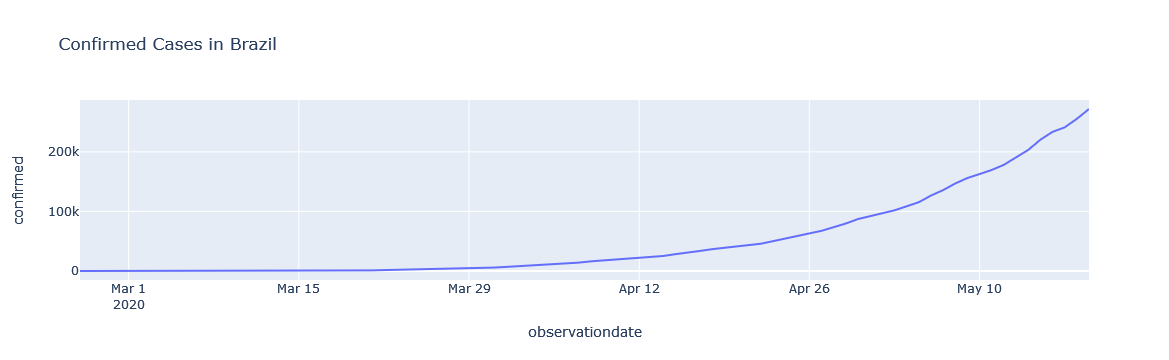

In [151]:
px.line(brasil, 'observationdate', 'confirmed', title = 'Confirmed Cases in Brazil')

---
### New Cases Per Day

In [152]:
# Returns the daily covid cases
brasil['newcases'] = list(map(
    lambda row: 0 if (row==0) else brasil['confirmed'].iloc[row] - brasil['confirmed'].iloc[row - 1], np.arange(brasil.shape[0])
))

C:\Users\PICHAU\AppData\Local\Temp\ipykernel_6832\610549047.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



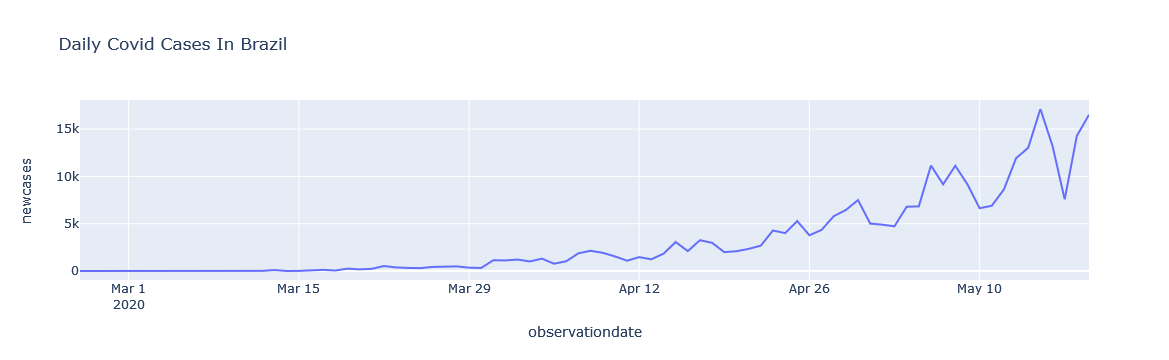

In [153]:
px.line(brasil, x = 'observationdate', y = 'newcases', title = 'Daily Covid Cases In Brazil')

### Deaths

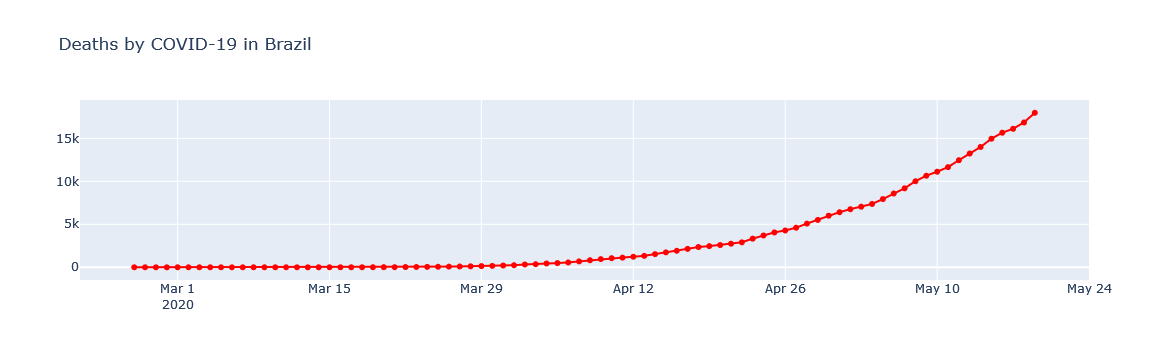

In [154]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(
    go.Scatter(x = brasil.observationdate, y= brasil.deaths, name = 'Mortes',
              mode = 'lines+markers', line = {'color': 'red'})
)

#layout
fig.update_layout(title = 'Deaths by COVID-19 in Brazil')

fig.show()

### Growth Rate

- growth_rate = (present/past)**(1/n) - 1 

In [155]:
def growth_rate(data, var, start = None, end = None):
    
    #if start date is None set the first date avaible
    if start == None:
        start = data.observationdate.loc[data[var] > 0].min()
    else:
        start = pd.to_datetime(start)
    
    if end == None:
        end = data.observationdate.iloc[-1]
    else:
        end = pd.to_datetime(end)
    
    #past and present dates values
    past = data.loc[data.observationdate == start, var].values[0]
    present = data.loc[data.observationdate == end, var].values[0]
    
    #number of time periods we'll be analyzing
    n = (end - start).days
    
    #calculate rate
    rate = (present/past)**(1/n) - 1
    
    return rate*100

In [156]:
growth_rate(brasil, 'confirmed')

16.27183353112116

In [157]:
def daily_growth_rate(data, var, start=None):
    #if start date is None set the first date avaible
    if start == None:
        start = data.observationdate.loc[data[var] > 0].min()
    else:
        start = pd.to_datetime(start)
        
    end = data.observationdate.max()
    
    n = (end - start).days
    
    rates = list(map(
        lambda x: (data[var].iloc[x] - data[var].iloc[x-1]) / data[var].iloc[x - 1],
        range(1, n + 1)
    ))
    
    return np.array(rates) * 100

In [158]:
daily_rates = daily_growth_rate(brasil, 'confirmed')

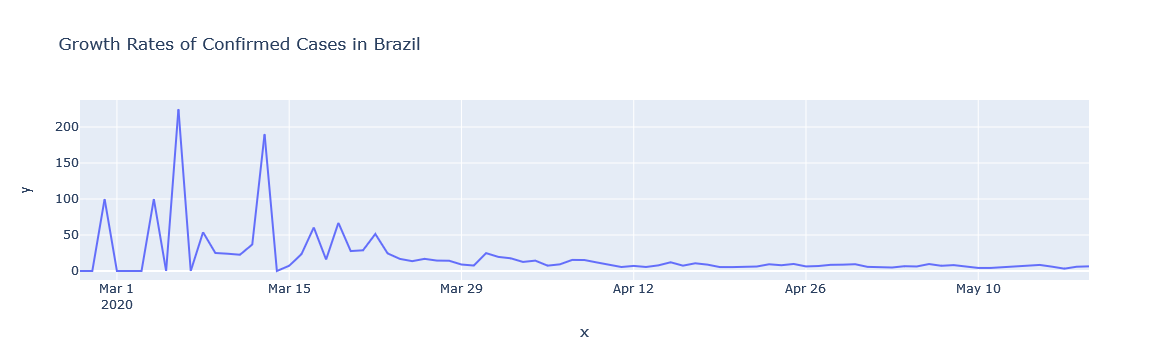

In [159]:
first_day = brasil.observationdate.loc[brasil.confirmed > 0].min()

px.line(x = pd.date_range(first_day, brasil.observationdate.max())[1:],
        y = daily_rates, title = 'Growth Rates of Confirmed Cases in Brazil'
       )

### Making predictions

In [160]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [161]:
confirmed_cases = brasil.confirmed
#setting observationdate as index
confirmed_cases.index = brasil.observationdate
confirmed_cases

observationdate
2020-02-26         1.0
2020-02-27         1.0
2020-02-28         1.0
2020-02-29         2.0
2020-03-01         2.0
                ...   
2020-05-15    220291.0
2020-05-16    233511.0
2020-05-17    241080.0
2020-05-18    255368.0
2020-05-19    271885.0
Name: confirmed, Length: 84, dtype: float64

In [162]:
res = seasonal_decompose(confirmed_cases)

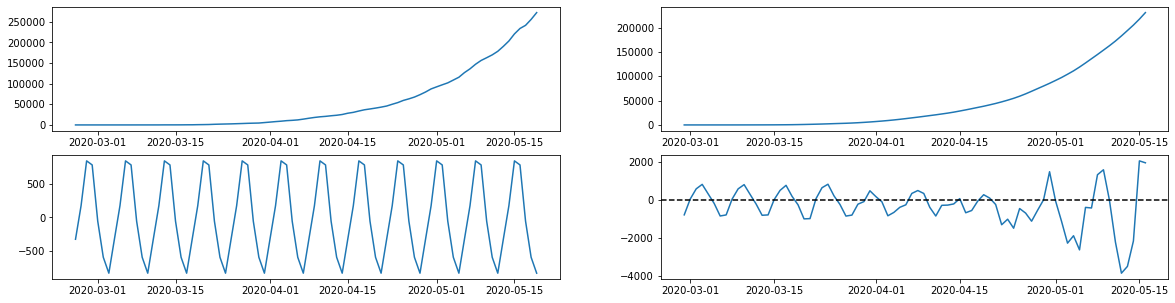

In [163]:
rows = 2
cols = 2
fig = plt.figure(figsize =(20,5))
fig.tight_layout(pad = 1.0)

#current series
ax = fig.add_subplot(2,2,1)
ax.plot(res.observed)

#trends
ax = fig.add_subplot(2,2,2)
ax.plot(res.trend)

#seasonality
ax = fig.add_subplot(2,2,3)
ax.plot(res.seasonal)

#residual
ax = fig.add_subplot(2,2,4)
ax.plot(confirmed_cases.index, res.resid)
ax.axhline(0, linestyle = '--', c = 'black')
plt.show()    

### ARIMA MODEL

In [164]:
from pmdarima.arima import auto_arima

model = auto_arima(confirmed_cases)

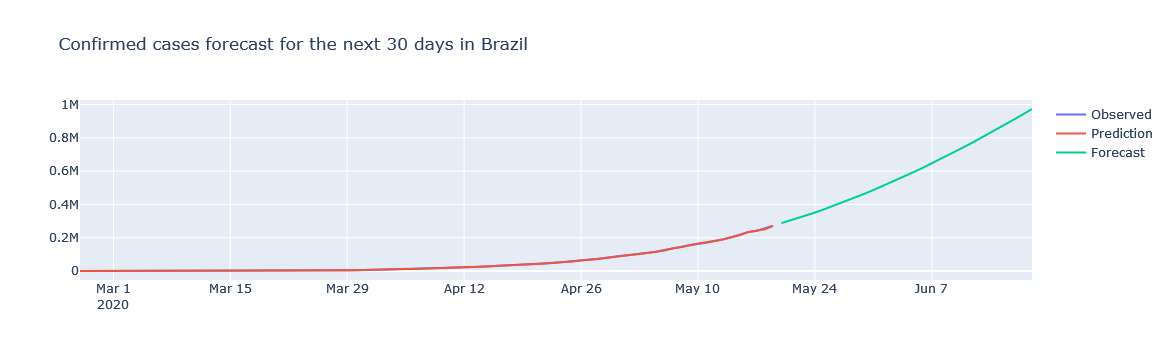

In [165]:
fig = go.Figure(go.Scatter(
                x = confirmed_cases.index, y = confirmed_cases, name = 'Observed'
               ))

fig.add_trace(go.Scatter(
    x = confirmed_cases.index, y=model.predict_in_sample(), name = 'Prediction'
))

fig.add_trace(go.Scatter(
    x = pd.date_range('2020-05-20', '2020-06-20'), y = model.predict(31), name = 'Forecast'
))

fig.update_layout(title= 'Confirmed cases forecast for the next 30 days in Brazil')
fig.show()

### Growth Model

In [167]:
from prophet import Prophet

In [169]:
#preprocessing

#all data excluding the last 5 cases
train = confirmed_cases.reset_index()[:-5]


test = confirmed_cases.reset_index()[-5:]

#Renaming Columns
train.rename(columns = {'observationdate':'ds', 'confirmed' : 'y'}, inplace = True)
test.rename(columns = {'observationdate':'ds', 'confirmed': 'y'}, inplace = True)

#Defining Growth Model
prophet = Prophet(growth = 'logistic', changepoints = ['2020-03-21','2020-03-30','2020-04-25', '2020-05-03','2020-05-10'])


pop = 211463256
train['cap'] = pop

#training
prophet.fit(train)

#predictions
future_dates = prophet.make_future_dataframe(periods =200)
future_dates['cap']=pop
forecast = prophet.predict(future_dates)

17:25:16 - cmdstanpy - INFO - Chain [1] start processing
17:25:17 - cmdstanpy - INFO - Chain [1] done processing


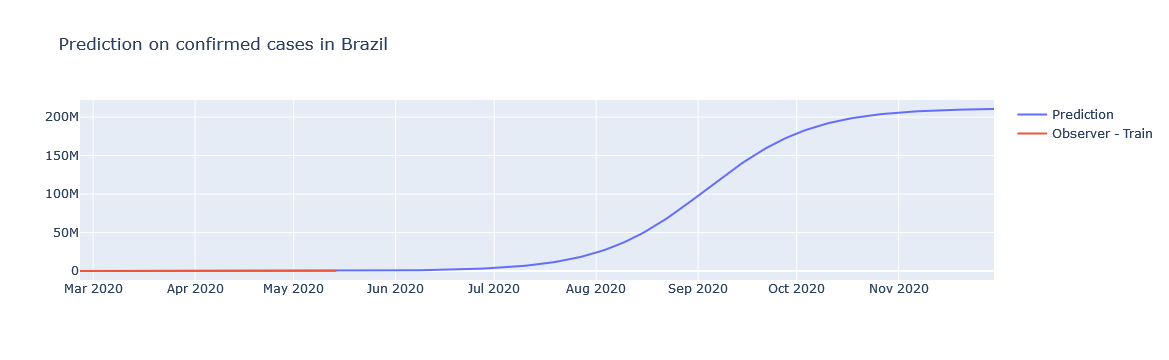

In [171]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat, name='Prediction'))
fig.add_trace(go.Scatter(x=train.ds, y=train.y, name='Observer - Train'))
fig.update_layout(title = 'Prediction on confirmed cases in Brazil')
fig.show()